# Лабораторная работа №3 "Проведение исследований с решающим деревом"

## Подключение вспомогательных библиотек

In [27]:
from typing import Union

import math
from dataclasses import dataclass
import collections

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn.metrics
import sklearn.model_selection
import sklearn.tree


## Классификация

### 2. Создание бейзлайна и оценка качества

#### Подготовка бейзлайна

Перед началом обучения модели сформируем бейзлайн, подобно тому, как это было выполнено в рамках лабораторной работы №1

In [2]:
!kaggle datasets download -q -p dataset -d saurabhbadole/bank-customer-churn-prediction-dataset
!unzip dataset/bank-customer-churn-prediction-dataset.zip -d dataset/

ds = pd.read_csv("dataset/Churn_Modelling.csv")
ds.head()

baseline_ds = ds.drop(columns=["RowNumber", "CustomerId", "Surname"])

baseline_ds = pd.get_dummies(baseline_ds, columns=["Geography"], dtype=int)
baseline_ds = pd.get_dummies(baseline_ds, columns=["Gender"], dtype=int)

baseline_ds.head()

Dataset URL: https://www.kaggle.com/datasets/saurabhbadole/bank-customer-churn-prediction-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
Archive:  dataset/bank-customer-churn-prediction-dataset.zip
  inflating: dataset/Churn_Modelling.csv  


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


#### Обучение модели

Перейдем теперь к этапу обучения модели. По аналогии с лабораторной работой №1, для этого создадим вспомогательные функции:

- `generate_train_data` - отвечает за то, чтобы сгенерировать набор данных для тестирования и обучения на основе переданного датасета

- `get_model_metrics` - отвечает за рассчет показаний метрик для уже обученной модели на основе тестовых данных

- `print_model_metrics` - отвечает за отформатированный вывод показаний метрик

In [3]:
def generate_train_data(dataset, *, target_feature="Exited", random_state=42, test_size=0.2):
  X = dataset.drop(columns=[target_feature])
  y = dataset[target_feature]

  X_train, X_test, y_train, y_test = map(
    np.array,
    sklearn.model_selection.train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
    ),
  )

  return (X_train, y_train), (X_test, y_test)


def get_model_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
  precision = sklearn.metrics.precision_score(y_test, y_pred)
  recall = sklearn.metrics.recall_score(y_test, y_pred)
  f1 = sklearn.metrics.f1_score(y_test, y_pred)

  confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

  return {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "confusion_matrix": confusion_matrix,
  }

def print_model_metrics(model, X_test, y_test):
  metrics = get_model_metrics(model, X_test, y_test)

  print(f"Accuracy: {metrics['accuracy']:.4f}")
  print(f"Precision: {metrics['precision']:.4f}")
  print(f"Recall: {metrics['recall']:.4f}")
  print(f"F1-Score: {metrics['f1']:.4f}")

  print("\nConfusion Matrix:")
  print(metrics["confusion_matrix"])


Обучим теперь модель решающего дерева для решения задачи классификации на бейзлайн-датасете, который мы ранее определили, и выведем на экран показатели метрик для итоговой обученной модели.

In [4]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.tree.DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.7790
Precision: 0.4454
Recall: 0.5089
F1-Score: 0.4751

Confusion Matrix:
[[1358  249]
 [ 193  200]]


На основе полученных данных можно сделать следующие выводы о качестве обученной модели.

Во-первых модель имеет довольно высокие значения "Accuracy", то есть правильно классифицирует примерно 78% всех примеров. Однако, стоит учитывать, что причиной такоим высоким значения метрики может послужить несбалансированность классов.

С другой стороны, если мы посмотрим на значение метрики "F1-Score", то заметим, что модель тоже не справляется с несбалансированностью данных.

Итого, при дальнейшем улучшении бейзлайна предлагается сделать упор на улучшение метрики "F1-Score", при этом сохранив значение для метрики "Accuracy" на том же уровне.

### 3. Улучшение бейзлайна

#### Нормализация данных

Решающее дерево чувствительно к распределению значений признаков. Если признак имеет сильно смещенное распределение, то модель может создавать слишком глубокие ветки, чтобы объяснить редкие значения в хвосте.

Данная проблема может быть решена путем преобразований значений признака, например, через логарифмирование. Через такие преобразования данные становятся более симметричными, а их распределение становится больше похожим на нормальное.

Рассмотрим признак `Age` и проанализируем его на наличие смещенного распределения. Для этого выведем 2 графика:
- Ящик с усами, который визуально демонстрирует основные параметры распределения
- Гистограмму, описывающую распределение значение

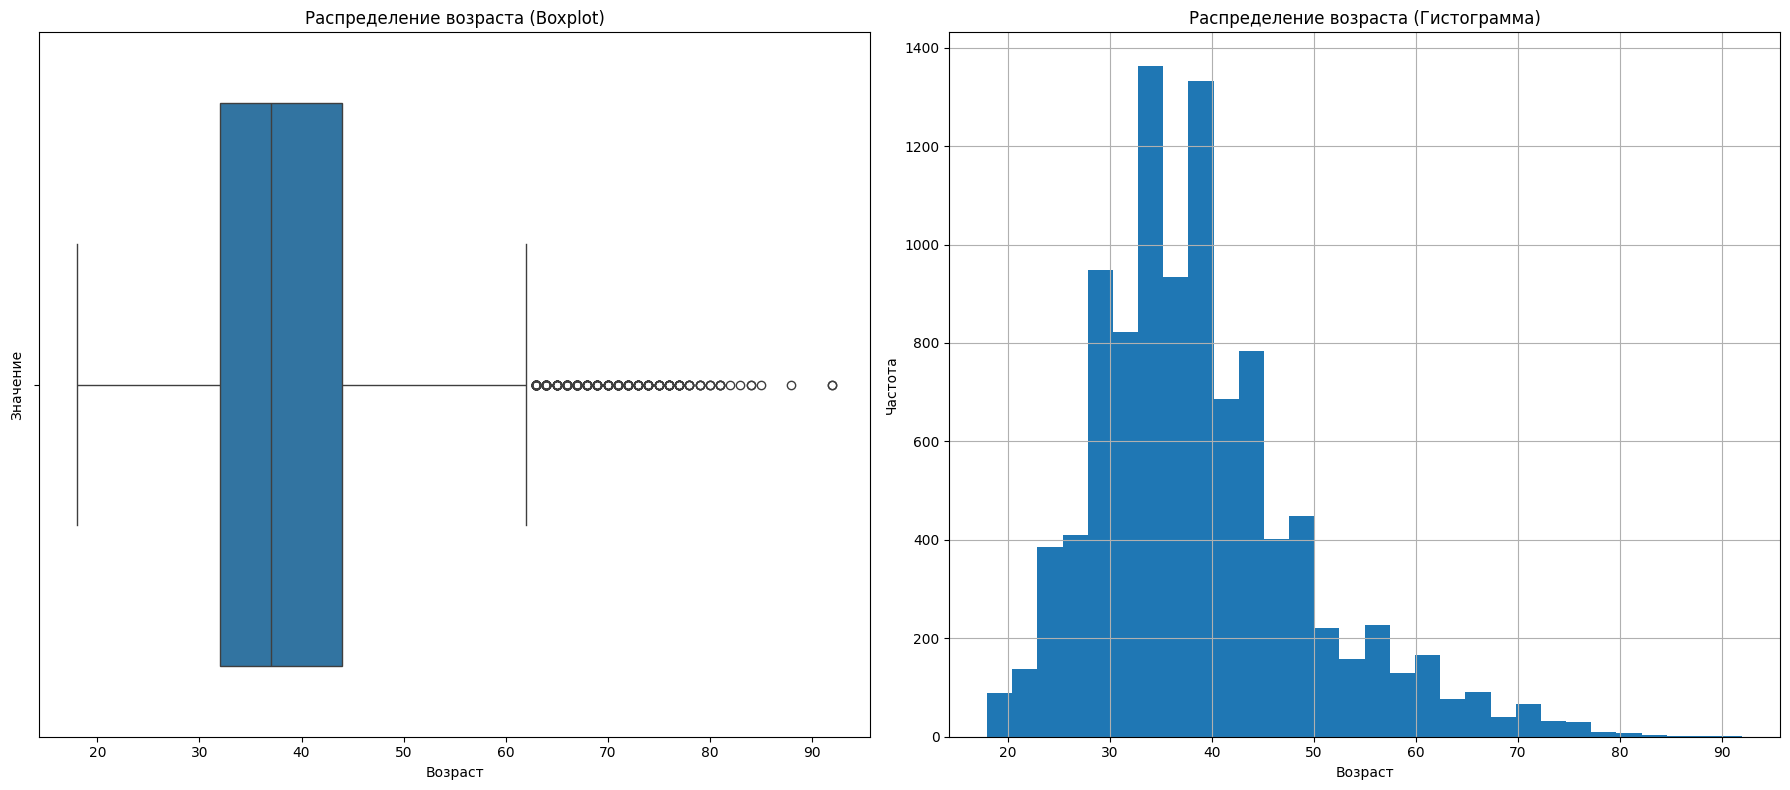

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.boxplot(x=baseline_ds["Age"], ax=axes[0])
axes[0].set_title("Распределение возраста (Boxplot)")
axes[0].set_xlabel("Возраст")
axes[0].set_ylabel("Значение")

baseline_ds[["Age"]].hist(bins=30, ax=axes[1])
axes[1].set_title("Распределение возраста (Гистограмма)")
axes[1].set_xlabel("Возраст")
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

Как видим, распределение значений признака `Age` действительно оказалось смещенным. Попробуем нормализовать значения, приведя распределение к нормальному, с использованием функции логарифма.

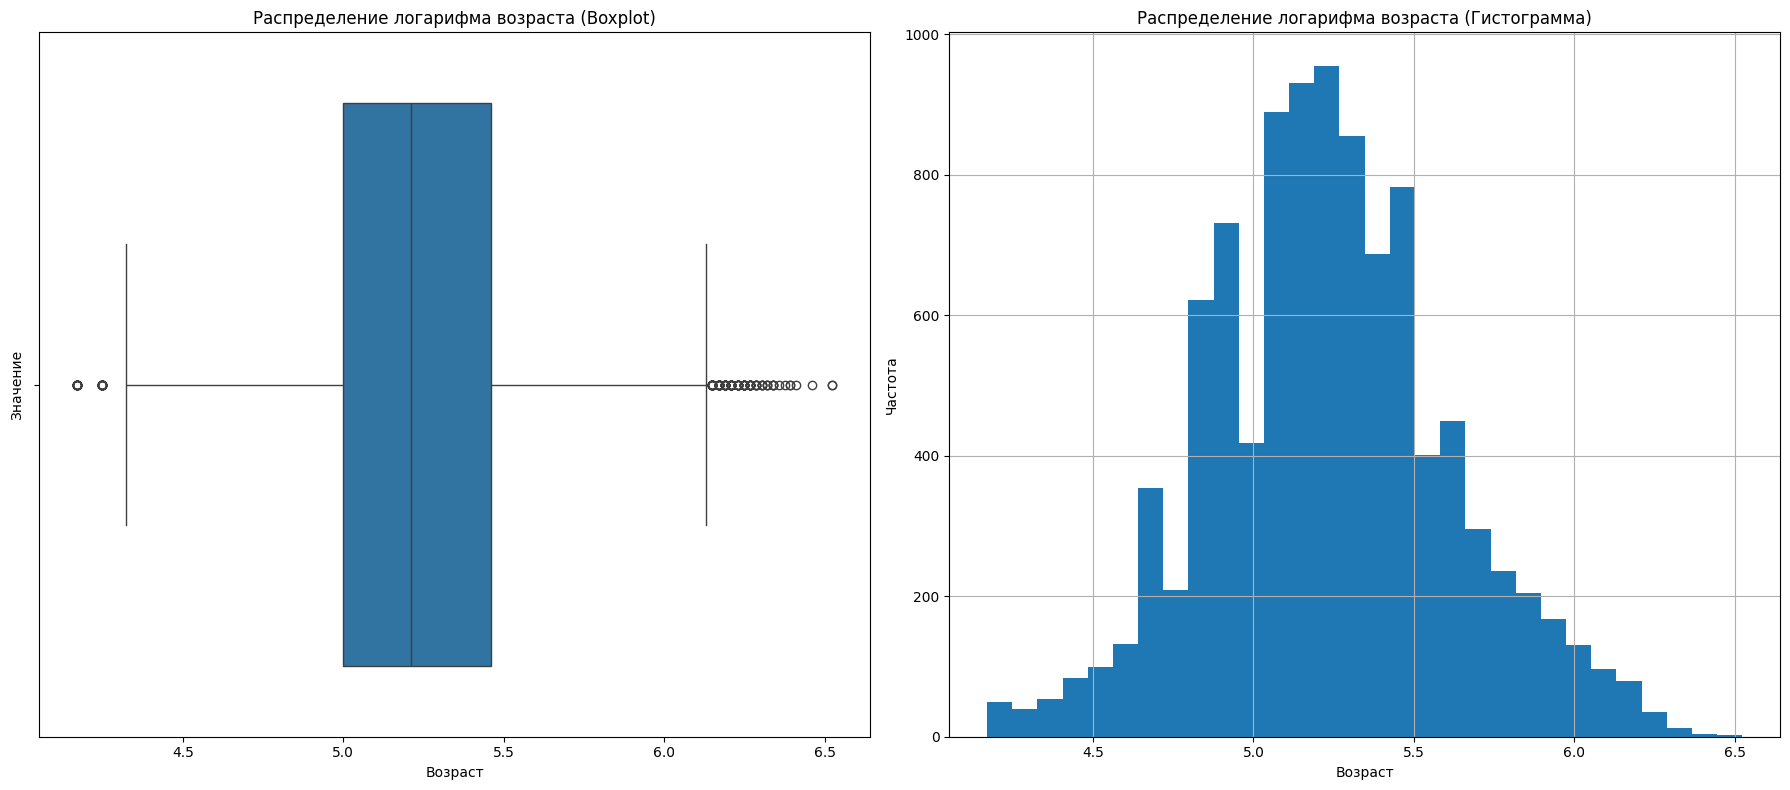

In [12]:
optimized_ds = baseline_ds.copy()
optimized_ds["Age_log"] = np.log2(optimized_ds["Age"])
optimized_ds.drop(columns=["Age"], inplace=True)

# Вывод распределений

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.boxplot(x=optimized_ds["Age_log"], ax=axes[0])
axes[0].set_title("Распределение логарифма возраста (Boxplot)")
axes[0].set_xlabel("Возраст")
axes[0].set_ylabel("Значение")

optimized_ds[["Age_log"]].hist(bins=30, ax=axes[1])
axes[1].set_title("Распределение логарифма возраста (Гистограмма)")
axes[1].set_xlabel("Возраст")
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

Как видим, теперь распределение значений признака `Age` стало все больше похоже на нормальное.

Проверим, улучшились ли показатели метрик после произведенных улучшений бейзлайна

In [16]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = sklearn.tree.DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.7870
Precision: 0.4619
Recall: 0.5089
F1-Score: 0.4843

Confusion Matrix:
[[1374  233]
 [ 193  200]]


Как видим, значения метрики оказались лучше, а следовательно, гипотеза оказалась верной!

#### Учитывание несбалансированности класса

При выполнении прошлых лабораторных работ отличные результаты показала гипотеза о наличи несбалансированности данных в датасете. Попробуем выполнить аналогичные улучшения датасета и для случая с решающим деревом.

In [17]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = sklearn.tree.DecisionTreeClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.8015
Precision: 0.4948
Recall: 0.4835
F1-Score: 0.4891

Confusion Matrix:
[[1413  194]
 [ 203  190]]


Как видим, значения метрики "Accuracy" и "F1-Score" улучшились! Гипотеза оказалась верной и дала положительные результаты, но не на столько эффективные, как в случае с линейными моделями и KNN алгоритмом.

#### Подбор гиперпараметров

Иногда значения гиперпараметров, установленные в модели по умолчанию, не всегда являются оптимальными для конкретного датасета.

Поэтому, иногда имеет смысл подобрать более оптимальные значения гиперпараетров, которые больше подходить для текущего датасета.

Попробуем подобрать такие значения гиперпараметров на основе алгоритма grid search.

In [26]:
param_grid = {
  "criterion": ["gini", "entropy"],
  "max_depth": [3, 5, 10, None],
  "min_samples_split": [2, 5, 10],
  "min_samples_leaf": [1, 2, 5, 10],
  "max_features": [None, "sqrt", "log2"]
}

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)
model = sklearn.tree.DecisionTreeClassifier(random_state=42, class_weight="balanced")

grid_search = sklearn.model_selection.GridSearchCV(
  estimator=model,
  param_grid=param_grid,
  cv=5,
  scoring="f1",
  verbose=1,
  n_jobs=-1,
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


print(f"Best Parameters: {best_params}")
print_model_metrics(best_model, X_test, y_test)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Accuracy: 0.7400
Precision: 0.4170
Recall: 0.8117
F1-Score: 0.5509

Confusion Matrix:
[[1161  446]
 [  74  319]]


Как видим, после подбора значений для гиперпараметров значение метрики "F1-Score" улучшилось, а следовательно гипотеза оказалась верной!

### 4. Имплементация алгоритма машинного обучения

Перейдем теперь к собственной имплементации алгоритма дерева решения для задачи классификации. Решение я реализовал в виде класса `MyDecisionTreeClassifier`, который имеет интерфейс, схожий с тем, что используется в библиотеке `sklearn`. присутствуют 2 метода: `fit` - для обучения модели, `predict` - для предсказания классов для уже обученной модели.


In [28]:
_PredictedClass = int


@dataclass
class _SplitInfo:
  index: int
  threshold: float


@dataclass
class _TreeNode:
  split_info: _SplitInfo
  left: Union["_TreeNode", _PredictedClass]
  right: Union["_TreeNode", _PredictedClass]


class MyDecisionTreeClassifier:
  def __init__(self, *, max_depth=float("inf")):
    self.__max_depth = max_depth
    self.__tree = None

  def __build_decision_tree(self, X, y, depth=0):
    n, m = X.shape
    unique_classes = set(y)

    if len(unique_classes) == 1 or n <= 1:
      return unique_classes.pop()

    if depth >= self.__max_depth:
      return collections.Counter(y).most_common(1)[0][0]

    best_split = self._best_split(X, y)
    left_part, right_part = self.__split_data(X, y, best_split)

    return _TreeNode(
      split_info=best_split,
      left=self.__build_decision_tree(*left_part, depth + 1),
      right=self.__build_decision_tree(*right_part, depth + 1),
    )

  def __split_data(self, X, y, split_info):
    x = X[:, split_info.index]
    left_ids = x <= split_info.threshold
    right_ids = x > split_info.threshold

    return (X[left_ids], y[left_ids]), (X[right_ids], y[right_ids])

  def _best_split(self, X, y):
    _, m = X.shape
    return max(
      (
        _SplitInfo(index=feature_index, threshold=threshold)
        for feature_index in range(m)
        for threshold in self.__get_thresholds(X, feature_index)
      ),
      key=lambda split_info: self.__get_info_gain(X, y, split_info.index, split_info.threshold),
      default=-float('inf'),
    )

  def __get_info_gain(self, X, y, feature_index, threshold):
    feature_values = X[:, feature_index]
    left_indices = feature_values <= threshold
    right_indices = feature_values > threshold

    if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
      return -float('inf')

    left_y = y[left_indices]
    right_y = y[right_indices]

    l = self.__get_entropy(left_y)
    r = self.__get_entropy(right_y)

    n = len(y)
    return self.__get_entropy(y) - (len(left_y) / n * l + len(right_y) / n * r)

  def __get_thresholds(self, X, feature_id):
    return np.unique(X[:, feature_id])

  def __get_entropy(self, y):
    class_counts = np.bincount(y)
    probabilities = class_counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

  def __predict(self, x):
    cursor = self.__tree

    while isinstance(cursor, _TreeNode):
      feature_value = x[cursor.split_info.index]
      predictor = feature_value <= cursor.split_info.threshold
      cursor = [cursor.right, cursor.left][predictor]

    return cursor

  def fit(self, X, y):
    self.__tree = self.__build_decision_tree(X, y)

  def predict(self, X):
    return np.array(list(map(self.__predict, X)))

#### Сравнение с бейзлайном

Обучим теперь реализованную модель на датасете, соответствущем бейзлайну. Из-за определенных ранее вспомогательных функций и схожего интерфейса класса модели основной алгоритм обучения не меняется.

In [30]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = MyDecisionTreeClassifier()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.7950
Precision: 0.4803
Recall: 0.5267
F1-Score: 0.5024

Confusion Matrix:
[[1383  224]
 [ 186  207]]


В сравнению с моделью из пункта 2 имплементированная модель показала более лучшие результаты: метрика "F1-Score" получила более высокие значения, что свидетельствует нам о том, что имплементированная модель лучше справляется с несбалансированными данными на бейзлайне.

In [34]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = MyDecisionTreeClassifier()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.7945
Precision: 0.4794
Recall: 0.5318
F1-Score: 0.5042

Confusion Matrix:
[[1380  227]
 [ 184  209]]


Как видим, на улучшенном бейзлайне модель показала почти такие же метрики, что и на бейзлайне до улучшений, и имеет результаты немного хуже, чем модель из пункта 3.

Обоснованно это отсутствием тонкой настройки гиперпараметров модели, в отличие от модели из пункта 3, что говорит нам о том, что подбор гиперпараметров оказывал значительное влияние на итоговое качество модели.

## Регрессия

### 2. Создание бейзлайна и оценка качества

#### Подготовка бейзлайна

Перед началом обучения модели сформируем бейзлайн, подобно тому, как это было выполнено в рамках лабораторной работы №1

In [35]:
!kaggle datasets download -q -p dataset -d denkuznetz/taxi-price-prediction
!unzip dataset/taxi-price-prediction.zip -d dataset/

Dataset URL: https://www.kaggle.com/datasets/denkuznetz/taxi-price-prediction
License(s): apache-2.0
Archive:  dataset/taxi-price-prediction.zip
  inflating: dataset/taxi_trip_pricing.csv  


In [37]:
ds = pd.read_csv("/content/dataset/taxi_trip_pricing.csv")
baseline_ds = ds.dropna(subset=["Trip_Price"])

numeric_features = [
  "Trip_Distance_km",
  "Passenger_Count",
  "Base_Fare",
  "Per_Km_Rate",
  "Per_Minute_Rate",
  "Trip_Duration_Minutes",
]
baseline_ds[numeric_features] = baseline_ds[numeric_features].apply(lambda col: col.fillna(col.median()))

categorical_features = [
  "Time_of_Day",
  "Day_of_Week",
  "Traffic_Conditions",
  "Weather",
]

for feature in categorical_features:
  encoded_feature = pd.get_dummies(baseline_ds[feature], prefix=feature, dtype=int)
  baseline_ds[encoded_feature.columns] = encoded_feature
  baseline_ds = baseline_ds.drop(columns=[feature])

baseline_ds.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekday,Day_of_Week_Weekend,Traffic_Conditions_High,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Clear,Weather_Rain,Weather_Snow
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624,0,0,1,0,1,0,0,1,0,1,0,0
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032,0,1,0,0,0,1,1,0,0,1,0,0
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698,0,1,0,0,1,0,0,1,0,0,0,0
4,25.87,3.0,2.93,0.63,0.32,22.64,15.6180,0,1,0,0,1,0,1,0,0,1,0,0
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028,1,0,0,0,0,1,0,0,1,1,0,0


#### Обучение модели

Перейдем теперь к этапу обучения модели. По аналогии с лабораторной работой №1, для этого создадим вспомогательные функции:

- `generate_train_data` - отвечает за то, чтобы сгенерировать набор данных для тестирования и обучения на основе переданного датасета

- `get_model_metrics` - отвечает за рассчет показаний метрик для уже обученной модели на основе тестовых данных

- `print_model_metrics` - отвечает за отформатированный вывод показаний метрик

In [38]:
def generate_train_data(dataset, *, target_feature="Trip_Price", test_size=0.2, random_state=42):
  X = dataset.drop(columns=[target_feature])
  y = dataset[target_feature]
  X_train, X_test, y_train, y_test = map(
    np.array,
    sklearn.model_selection.train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
    ),
  )

  return (X_train, y_train), (X_test, y_test)


def get_model_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
  r2 = sklearn.metrics.r2_score(y_test, y_pred)

  return { "mae": mae, "r2": r2 }


def print_model_metrics(model, X_test, y_test):
  results = get_model_metrics(model, X_test, y_test)

  print(f"Mean Absolute Error (MAE): {results['mae']:.4f}")
  print(f"R-squared (R2): {results['r2']:.4f}")

Обучим теперь модель линейной регрессии для решения задачи регрессии на бейзлайн-датасете, который мы ранее определили и выведем на экран показатели метрик для итоговой обученной модели.

In [39]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.tree.DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 10.5485
R-squared (R2): 0.8504


На основе полученных данных можно сделать следующие выводы о качестве обученной модели.

Во-первых, высокое значение метрики "R2" свидетельствует о том, что модель хорошо обучена и способна учитывать основные факторы, влияющие на цену поездки.

Однако, ошибка в предсказываемой цене поездки, описываемая метрикой `MAE` может значительно сказаться для поездок с маленькой стоимостью.

Итого, дальнейшее улучшение бейзлайна предлагается делать с упором на уменьшение значений метрики `MAE`.

### 3. Улучшение бейзлайна

#### Избавление от выбросов

При решении лабораторной работы №2 значительной прирост в итоговом качестве модели оказало избавление от выбросов среди значений признаков.

Попробуем применить эту же гипотезу к дереву решений. При решении лабораторной работы №2 среди таких признаков был взят признак `Trip_Distance_km`, описывающий длину поездки, выраженную в киолметрах.

Рассмотрим этот же признак и уберем из его значений выбросы.

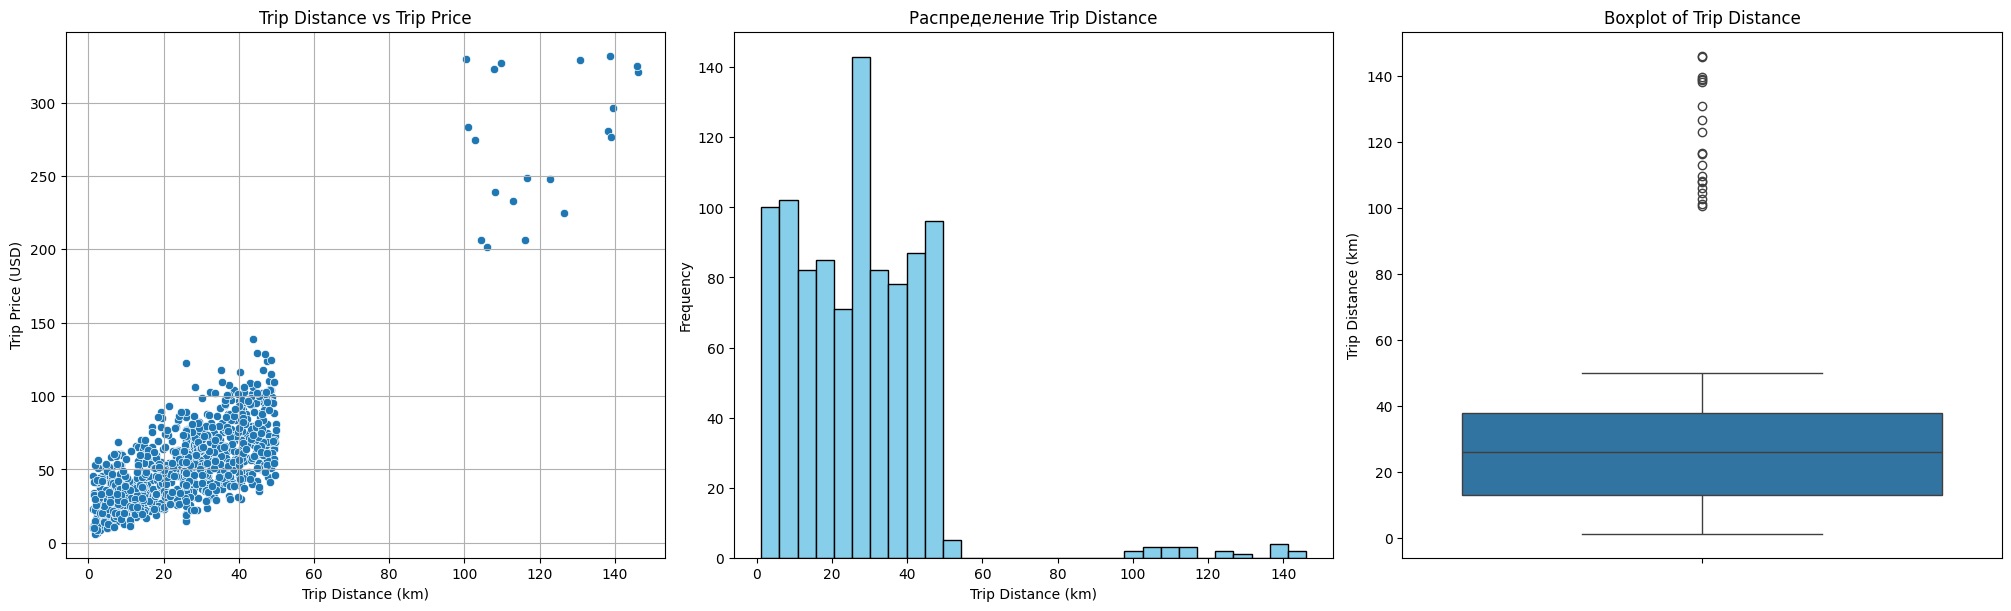

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

sns.scatterplot(
    x="Trip_Distance_km",
    y="Trip_Price",
    data=baseline_ds,
    ax=axes[0]
)
axes[0].set_title("Trip Distance vs Trip Price")
axes[0].set_xlabel("Trip Distance (km)")
axes[0].set_ylabel("Trip Price (USD)")
axes[0].grid(True)

axes[1].hist(baseline_ds["Trip_Distance_km"], bins=30, color="skyblue", edgecolor="black")
axes[1].set_title("Распределение Trip Distance")
axes[1].set_xlabel("Trip Distance (km)")
axes[1].set_ylabel("Frequency")

sns.boxplot(
    y="Trip_Distance_km",
    data=baseline_ds,
    ax=axes[2]
)
axes[2].set_title("Boxplot of Trip Distance")
axes[2].set_ylabel("Trip Distance (km)")

plt.show()

In [41]:
Q1 = baseline_ds["Trip_Distance_km"].quantile(0.25)
Q3 = baseline_ds["Trip_Distance_km"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

optimized_ds = baseline_ds[(lower_bound <= baseline_ds["Trip_Distance_km"]) & (baseline_ds["Trip_Distance_km"] <= upper_bound)]
optimized_ds.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekday,Day_of_Week_Weekend,Traffic_Conditions_High,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Clear,Weather_Rain,Weather_Snow
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624,0,0,1,0,1,0,0,1,0,1,0,0
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032,0,1,0,0,0,1,1,0,0,1,0,0
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698,0,1,0,0,1,0,0,1,0,0,0,0
4,25.87,3.0,2.93,0.63,0.32,22.64,15.6180,0,1,0,0,1,0,1,0,0,1,0,0
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028,1,0,0,0,0,1,0,0,1,1,0,0


Проверим, улучшились ли показатели метрик после произведенных улучшений бейзлайна

In [42]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = sklearn.tree.DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 8.1763
R-squared (R2): 0.8125


Как видим, после удаления выбросов из значений модель стала показывать более лучшие показатели метрик. А следовательно гипотеза оказалась верной!

#### Feature engineering

Также, при выполнении лабораторной работы №2 значительный прирост в качестве модели дало применение feature engineering к датасету.

Попробуем применить аналогичную гипотезу к дереву решений. При решении лабораторной работы №2 в качестве пары, на основе которых был выполнен feature engineering, были выбраны признаки `Trip_Distance_km` и `Per_Km_Rate`.

Выберем их и в этот раз.

In [43]:
optimized_ds_2 = optimized_ds.copy()

optimized_ds_2["Per_Km_Rate__Trip_Distance_km"] = optimized_ds_2["Trip_Distance_km"] * optimized_ds_2["Per_Km_Rate"]
optimized_ds_2 = optimized_ds_2.drop(columns=["Trip_Distance_km", "Per_Km_Rate"])

# обучение модели

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_2)

model = sklearn.tree.DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 6.0479
R-squared (R2): 0.8744


Как видим, в этот раз генерация дополнительных признаков с использованием нелинейных функций также дало значительный прирост в качестве обученной модели. А следовательно гипотеза оказалась верной!

In [44]:
optimized_ds_3 = optimized_ds_2.copy()

optimized_ds_3["Per_Minute_Rate__Trip_Duration_Minutes"] = optimized_ds_3["Trip_Duration_Minutes"] * optimized_ds_3["Per_Minute_Rate"]
optimized_ds_3 = optimized_ds_3.drop(columns=["Trip_Duration_Minutes", "Per_Minute_Rate"])

# обучение модели

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_3)

model = sklearn.tree.DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 4.5665
R-squared (R2): 0.9114


Аналогично с лабораторной работой №2, попробуем также применить feature engineering к паре признаков `Trip_Duration_Minutes` и `Per_Minute_Rate`.

Как видим, данная оптимизация датасета снова дала положительный результат, и показатели метрик `MAE` уменьшились, а метрики `R2` - увеличились.

#### Подбор гиперпараметров

Иногда значения гиперпараметров, установленные в модели по умолчанию, не всегда являются оптимальными для конкретного датасета.

Поэтому, иногда имеет смысл подобрать более оптимальные значения гиперпараетров, которые больше подходить для текущего датасета.

Попробуем подобрать такие значения гиперпараметров на основе алгоритма grid search.

In [47]:
param_grid = {
  "criterion": ["squared_error", "friedman_mse", "absolute_error"],
  "max_depth": [3, 5, 10, 20, 40, None],
  "min_samples_split": [2, 5, 10],
  "min_samples_leaf": [1, 2, 5, 10],
  "max_features": [None, "sqrt", "log2"],
}

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_3)
model = sklearn.tree.DecisionTreeRegressor(random_state=42)

grid_search = sklearn.model_selection.GridSearchCV(
  estimator=model,
  param_grid=param_grid,
  cv=5,
  scoring="neg_mean_squared_error",
  n_jobs=-1,
)

grid_search.fit(X_train, y_train)

# Вывод результатов

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print_model_metrics(best_model, X_test, y_test)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Mean Absolute Error (MAE): 3.5845
R-squared (R2): 0.9511


Как видим, нам удалось подобрать значения гиперпараметров, оптимальные конкретно для дерева решения для решения задачи регрессии. Гипотеза о наличии более оптимального набора значени гиперпараметров оказалась верной.

### 4. Имплементация алгоритма машинного обучения

Перейдем теперь к собственной имплементации алгоритма дерева решения для задачи регрессии. Решение я реализовал в виде класса `MyDecisionTreeRegressor`, который имеет интерфейс, схожий с тем, что используется в библиотеке `sklearn`. присутствуют 2 метода: `fit` - для обучения модели, `predict` - для предсказания классов для уже обученной модели.

Сама логика внутри такого класса почти ни чем не отличается от той, которая была написана для решения задачи классификации. Оличия заключаются лишь в логике предсказания значений.

In [52]:
_PredictedClass = int


@dataclass
class _SplitInfo:
  index: int
  threshold: float


@dataclass
class _TreeNode:
  split_info: _SplitInfo
  left: Union["_TreeNode", _PredictedClass]
  right: Union["_TreeNode", _PredictedClass]



# TODO: make a base class for regressor & classifier
class MyDecisionTreeRegressor:
  def __init__(self, *, max_depth=float("inf")):
    self.__max_depth = max_depth
    self.__tree = None

  def __build_decision_tree(self, X, y, depth=0):
    n, _ = X.shape
    unique_classes = set(y)

    if len(unique_classes) == 1 or n <= 1:
      return unique_classes.pop()

    if depth >= self.__max_depth:
      return collections.Counter(y).most_common(1)[0][0]

    best_split = self.__get_best_split(X, y)
    left_part, right_part = self.__split_data(X, y, best_split)

    return _TreeNode(
      split_info=best_split,
      left=self.__build_decision_tree(*left_part, depth + 1),
      right=self.__build_decision_tree(*right_part, depth + 1),
    )

  def __split_data(self, X, y, split_info):
    x = X[:, split_info.index]
    left_ids = x <= split_info.threshold
    right_ids = x > split_info.threshold

    return (X[left_ids], y[left_ids]), (X[right_ids], y[right_ids])

  def __get_best_split(self, X, y):
    _, m = X.shape
    return max(
      (
        _SplitInfo(index=feature_index, threshold=threshold)
        for feature_index in range(m)
        for threshold in self.__get_thresholds(X, feature_index)
      ),
      key=lambda split_info: self.__get_variance_reduction(X, y, split_info.index, split_info.threshold),
      default=-float('inf'),
    )

  def __get_variance_reduction(self, X, y, feature_index, threshold):
    feature_values = X[:, feature_index]
    left_indices = feature_values <= threshold
    right_indices = feature_values > threshold

    if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
      return -float('inf')

    left_y = y[left_indices]
    right_y = y[right_indices]

    n = len(y)
    left_var = np.var(left_y) * len(left_y) / n
    right_var = np.var(right_y) * len(right_y) / n

    return np.var(y) - (left_var + right_var)

  def __get_thresholds(self, X, feature_id):
    return np.unique(X[:, feature_id])

  def __predict(self, x):
    cursor = self.__tree

    while isinstance(cursor, _TreeNode):
      feature_value = x[cursor.split_info.index]
      cursor = cursor.left if feature_value <= cursor.split_info.threshold else cursor.right

    return cursor

  def fit(self, X, y):
    self.__tree = self.__build_decision_tree(X, y)

  def predict(self, X):
    return np.array(list(map(self.__predict, X)))

In [53]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = MyDecisionTreeRegressor()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 10.2323
R-squared (R2): 0.8589


Как видим, на бейзлайне без оптимизаций имплементированная модель показала значения метрик даже немного лучше, чем модель из пункта 2. Воможно, это связано с настройкой глубины дерева по умолчанию: в модели из пункта 2 по умолчанию глубина дерева конечна, в то время как в имплементированной модели такого ограничения нет.

In [54]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_3)

model = MyDecisionTreeRegressor(max_depth=10)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 5.1859
R-squared (R2): 0.9033


На улучшенном бейзлайне модель стала показывать значения метрик, значительно олучше, чем бейзлайне до оптимизаций. Однако, по сравнению с моделью из пункта 3 показатели метрик оказались хуже, что вероятно связано с отсутствием тонкой настройки гиперпараметров.